<a href="https://colab.research.google.com/github/ryangithubaccount/DSA2000/blob/main/CS101_Rnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#@title Mount Drive

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#@title Imports

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import pickle

In [ ]:
#@title Hyperparameters

class Resnet_Hyperparams():
    def __init__(self, train_loader):
        self.iterations = len(train_loader)
        self.epochs =  64000
        self.lr = 0.1
        self.momentum = 0.9
        self.weight_decay = 0.0001
        self.milestones = [32000,
                           48000]
        self.lr_multiplier = 0.1

In [ ]:
#@title Model Run Setup

DEBUG=False

def f1_score ( threshold, y_pred, y_true ):
    bc_pred = (y_pred > threshold).astype(int)
    tp = np.sum(np.logical_and(bc_pred == 1, y_true == 1))
    fp = np.sum(bc_pred == 1) - tp
    fn = np.sum(np.logical_and(bc_pred == 0, y_true == 1))

    precision = 0
    if tp != 0:
      precision = tp / (tp + fp)
    recall = 0
    if tp != 0:
      recall = tp / (tp + fn)
    f1 = 0
    if precision != 0 and recall != 0:
      f1 = 2 * precision * recall / (precision + recall)
    return precision, recall, f1

def inference(model, data_loader, device):
    flag = False
    y_true = None
    y_pred = None
    model.eval()
    with torch.no_grad():
        for data in data_loader:
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)

            if flag:
              y_true = np.concatenate((y_true, labels.cpu()))
              y_pred = np.concatenate((y_pred, outputs.cpu()))
            else:
              y_true = np.array(labels.cpu())
              y_pred = np.array(outputs.cpu())
              flag = True
    return y_pred, y_true

def evaluate ( threshold, model, data_loader, device ):
    '''
    Calculate the classification error in (%)
    '''
    y_pred, y_true = inference(model, data_loader, device)
    return f1_score(threshold, y_pred, y_true)

def run(model, epochs, train_loader, criterion, optimizer, RESULTS_PATH, validation_loader=None, scheduler=None, MODEL_PATH=None, VAL_PATH=None):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print(f' Using {device}')
    model.to(device)
    col_names = ['epoch', 'train_loss', 'precision_train', 'recall_train', 'f1_score_train', 'precision_validation', 'recall_validation', 'f1_score_validation']
    results_df = pd.DataFrame(columns=col_names).set_index('epoch')

    best_validation_f1 = 0
    for epoch in range(int(epochs)):
        model.train()

        total_loss = []

        for i, data in enumerate(train_loader, 0):
            x, y = data
            x, y = x.to(device), y.to(device)

            optimizer.zero_grad()

            prediction = model(x).to(device)
            loss = criterion(prediction, y)
            # loss.requires_grad= True
            loss.backward()
            optimizer.step()

            total_loss.append ( loss.item() )
            if i % 50 == 49:
                if DEBUG:
                    print(f'{epoch +1} \t{i+1} \t{np.mean(total_loss)}' )

        if scheduler != None:
            scheduler.step()
        train_loss = np.mean(total_loss)
        precision_train, recall_train, f1_score_train = evaluate(0.5, model, train_loader, device)
        precision_validation, recall_validation, f1_score_validation = (0, 0, 0)
        if validation_loader != None:
          precision_validation, recall_validation, f1_score_validation = evaluate(0.5, model, validation_loader, device)
        if f1_score_validation > best_validation_f1:
          best_validation_f1 = f1_score_validation
          torch.save(model, VAL_PATH)
        results_df.loc[epoch] = [train_loss, precision_train, recall_train, f1_score_train, precision_validation, recall_validation, f1_score_validation]
        results_df.to_csv ( RESULTS_PATH )
        print(f'epoch: {epoch+1} f1_train: {f1_score_train} f1_validation:{f1_score_validation} train_loss: {train_loss}')

    torch.save(model, MODEL_PATH)
    print('Finished Training')


In [ ]:
#@title Resnet Definition

class Block(nn.Module):
    def __init__(self, out_channels, stride=1):
        super().__init__()
        self.out_channels = out_channels
        self.kernel_size = 3
        self.padding = 1
        self.stride = stride

        in_channels1 = out_channels
        in_channels2 = out_channels
        if stride != 1:
            in_channels1 = in_channels1 // 2

        self.conv1 = nn.Conv2d(in_channels=in_channels1, out_channels=out_channels, padding=self.padding,
                               kernel_size=self.kernel_size, stride=stride, bias=False)
        self.batchnorm = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()
        self.conv2 = nn.Conv2d(in_channels=in_channels2, out_channels=out_channels, padding=self.padding,
                               kernel_size=self.kernel_size, stride=1, bias=False)


        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def skip_connection(self, F, X):
        '''
        F (tensor): block input
        x (tensor): activations of the block before relu

        If dimensions of input x are greater than activations then downsample and
        zero padding dimension 1 as described by option A in paper.
        '''
        X = X.to(torch.float32)
        F = F.to(torch.float32)
        if X.shape == F.shape:
            return torch.add(F, X)
        else:
            avgpool = nn.AvgPool2d(1, stride=2)
            X = avgpool(X)
            X = nn.functional.pad(X, (0, 0, 0, 0, 0, F.shape[1] - X.shape[1]), value=0)
            return torch.add(F, X)

    def forward(self, X):
        F = self.conv1(X)
        F = self.batchnorm(self.conv2(self.relu(self.batchnorm((F)))))
        F = self.skip_connection(F, X)
        out = self.relu(F)
        return out


class Resnet(nn.Module):
    def __init__(self, N, stride=2):
        super().__init__()

        # Input
        self.conv = nn.Conv2d ( 1, 16, kernel_size=3, stride=1, padding=1, bias=False )
        self.bn = nn.BatchNorm2d ( 16, track_running_stats=True )
        self.relu = nn.ReLU()

        self.stack1 = nn.ModuleList([Block(16) for _ in range(N)])

        self.stack2 = nn.ModuleList([Block(32, stride=stride)] + [Block(32) for _ in range(N - 1)])

        self.stack3 = nn.ModuleList([Block(64, stride=stride)] + [Block(64) for _ in range(N - 1)])

        self.upsample1 = nn.Sequential(nn.Upsample(scale_factor=2),
                                        nn.Conv2d(64, 32, kernel_size=3, padding=1, bias=False))

        self.upsample2 = nn.Sequential(nn.Upsample(scale_factor=2),
                                        nn.Conv2d(32, 16, kernel_size=3, padding=1, bias=False))

        self.final_conv = nn.Conv2d(16, 1, kernel_size=3, padding=1, bias=False)

        self.sigmoid = nn.Sigmoid()

        # init weights in the fully connected layer
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight)
                m.bias.data.zero_()


    def forward(self, X):
        with torch.profiler.profile(
            profile_memory=False,
            record_shapes=False,
        ) as prof:
            out = self.relu(self.bn(self.conv(X)))

            for layer in self.stack1:
                out = layer.forward(out)

            for layer in self.stack2:
                out = layer.forward(out)

            for layer in self.stack3:
                out = layer.forward(out)

            # out = self.reshape_layer(out)
            out = self.upsample1(out)
            out = self.upsample2(out)
            out = self.final_conv(out)

            out = self.sigmoid(out)

            prof.step()

        return out

In [ ]:
#@title Loss Definitions

def l1_loss(output, target):
    loss = torch.mean(abs(output - target))
    return loss

def cross_entropy(output, target):
    -(target*np.log(output)).sum(axis=(0, 1))

def weighted_bce_loss(output, target):
    x = -torch.mean(1 / abs(target-0.95)*(target*(torch.log(output + 1e-20)) + (1 - target)*torch.log(1 - output + 1e-20)))
    return x

def f1_loss(y_pred, y_true):
    bc_pred = (y_pred > 0.5)
    tp = torch.sum(torch.where((bc_pred) & (y_true == 1), 1, 0))
    fp = torch.sum(torch.where(bc_pred, 1, 0)) - tp
    fn = torch.sum(torch.where((bc_pred == False) & (y_true == 1), 1, 0))
    return 1 - (tp / (tp + 1/2 * (fp+fn)))

## Data Loader

In [ ]:
#@title Loader Definition

def load_data(train_dataset, labels,
                      batch_size):

    tensor_x = torch.Tensor(train_dataset) # transform to torch tensor
    tensor_y = torch.Tensor(labels)

    train_dataset = TensorDataset(tensor_x,tensor_y)
    train_loader = DataLoader(train_dataset, batch_size=batch_size)

    return train_dataset, train_loader

In [ ]:
#@title Initialize Data
batch_size = 64

data = np.load('/content/drive/MyDrive/CS 101 Group/data/real_rfi_data.npy')
labels = np.load('/content/drive/MyDrive/CS 101 Group/data/real_rfi_labels.npy')
size = np.shape(data)[0]
print(np.shape(data))
print(np.shape(labels))

train_dataset = data[:int(size * 0.7)]
train_labels = labels[:int(size * 0.7)]
validation_dataset = data[int(size * 0.7): int(size * 0.85)]
validation_labels = labels[int(size * 0.7): int(size * 0.85)]
test_dataset = data[int(size * 0.85):]
test_labels = labels[int(size * 0.85):]

train_dataset = (train_dataset - np.mean(train_dataset)) / np.std(train_dataset)
validation_dataset = (validation_dataset - np.mean(validation_dataset)) / np.std(validation_dataset)
test_dataset = (test_dataset - np.mean(test_dataset)) / np.std(test_dataset)

_, train_loader = load_data(train_dataset, train_labels, batch_size)
_, validation_loader = load_data(validation_dataset, validation_labels, np.shape(validation_dataset)[0])
_, test_loader = load_data(test_dataset, test_labels, np.shape(test_dataset)[0])

(13533, 1, 24, 100)
(13533, 1, 24, 100)


In [ ]:
#@title Load Model

model = torch.load('/content/drive/MyDrive/CS 101 Group/resnet_models/Simul/unweighted1')
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)
print(device)

cuda:0


In [ ]:
#@title Inference

y_pred, _ = inference(model, test_loader, device)
# np.save('/content/drive/MyDrive/CS 101 Group/resnet_models/real_data_test_set_from_simul', y_pred)

In [ ]:
#@title Evaluation on Expert
batch_size = 64

data = []
directory = '/content/drive/MyDrive/CS 101 Group/Expert Data'
with open('{}/LOFAR_Full_RFI_dataset.pkl'.format(directory),'rb') as f:
  data = pickle.load(f)

x = np.transpose(data[0][:2000], (0, 3, 1, 2))
y = np.transpose(data[1][:2000], (0, 3, 1, 2))
x = (x - np.mean(x)) / np.std(x)
_, expert_loader = load_data(x, y, batch_size)

precision, recall, f1_score = evaluate(0.5, model, expert_loader, device)

In [ ]:
#@title Train New Model

rnet = Resnet(5, stride=2)

criterion = nn.BCELoss()
# criterion = nn.BCELoss()

params = Resnet_Hyperparams ( train_loader )
params.lr=0.001
params.epochs=80
params.milestones[0]=int(params.epochs*1/2)
params.milestones[1]=int(np.ceil(params.epochs*3/4))
params.weight_decay = 5e-4

optimizer = torch.optim.Adam(params=rnet.parameters(), lr=params.lr)

results_file = '/content/drive/MyDrive/CS 101 Group/resnet_error/Real/realrfi2.csv'
model_file = '/content/drive/MyDrive/CS 101 Group/resnet_models/Real/realrfi2'
val_file = '/content/drive/MyDrive/CS 101 Group/resnet_models/Real/realrfi2_val'

run(rnet, params.epochs, train_loader, criterion,
          optimizer, results_file, MODEL_PATH=model_file, VAL_PATH=val_file, validation_loader=validation_loader)

 Using cuda:0
epoch: 1 f1_train: 0.017096592597868474 f1_validation:0.01764638989764371 train_loss: 0.18493068394335835
epoch: 2 f1_train: 0.06217692603879422 f1_validation:0.06360845891945073 train_loss: 0.13790033439343627
epoch: 3 f1_train: 0.12236305661212193 f1_validation:0.12420423619094556 train_loss: 0.11484385979446497
epoch: 4 f1_train: 0.1902799876246325 f1_validation:0.19130503654645434 train_loss: 0.10192658474499529
epoch: 5 f1_train: 0.2163774576903129 f1_validation:0.21724952583768675 train_loss: 0.09222316565838727
epoch: 6 f1_train: 0.2502493338232524 f1_validation:0.25057356859377333 train_loss: 0.08423235829580913
epoch: 7 f1_train: 0.24152886277187072 f1_validation:0.24238551534366107 train_loss: 0.07683895670554855
epoch: 8 f1_train: 0.31390833031260185 f1_validation:0.31433938217666735 train_loss: 0.07549594034525481
epoch: 9 f1_train: 0.3110376921983061 f1_validation:0.31140396563252887 train_loss: 0.06641374626620249
epoch: 10 f1_train: 0.307840002688122 f1_val

In [ ]:
#@title Continue Training Model

model_file = '/content/drive/MyDrive/CS 101 Group/resnet_models/resnet_upsample'
results_file = '/content/drive/MyDrive/CS 101 Group/resnet_error/resnet_training_err_cross_entropy_temp.csv'

rnet = torch.load(model_file)

criterion = nn.BCELoss()
params = Resnet_Hyperparams ( train_loader )
params.lr=0.00001
params.epochs=100
params.weight_decay = 5e-4

optimizer = torch.optim.Adam(params=rnet.parameters(), lr=params.lr, weight_decay=params.weight_decay)

run(rnet, params.epochs, train_loader, criterion,
          optimizer, results_file, MODEL_PATH=model_file)

best f1:  0.6471459608927513
optimal threhold:  0.8300000000000001


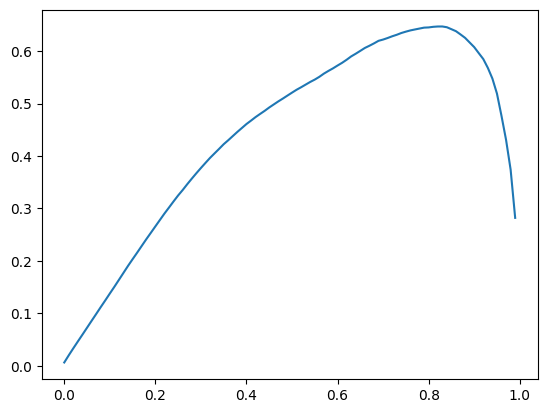

In [ ]:
#@title Treshold Tuning

def tune_threshold(model, dataloader):
  optimal_threshold = 0
  best_f1 = 0
  f1s = np.zeros((100, 2))
  y_pred, y_true = inference(model, dataloader, device)
  for i in range(100):
    precision, recall, f1 = f1_score(i * 0.01, y_pred, y_true)
    f1s[i] = [i * 0.01, f1]
    if f1 > best_f1:
      best_f1 = f1
      optimal_threshold = i * 0.01
  plt.plot(f1s[:, 0], f1s[:, 1])
  print("best f1: ", best_f1)
  print("optimal threhold: ", optimal_threshold)

tune_threshold(model, test_loader)

In [ ]:
#@title Visualization Function

def visualize(threshold, model, dataloader):
  device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
  model.to(device)
  model.eval()
  for x, y in dataloader:
      x, y = x.to(device), y.to(device)
      output = model(x).cpu().detach().numpy()
      bc_output = (output > threshold).astype(int)

      plt.imshow(x.cpu()[0][0])
      plt.xlabel('Time (samples)')
      plt.ylabel('Frequency (channel)')
      plt.title('Input Radio Frequency')
      plt.show()

      plt.imshow(output[0][0])
      plt.xlabel('Time (samples)')
      plt.ylabel('Frequency (channel)')
      plt.title('Model Output')
      plt.show()

      plt.imshow(y.cpu()[0][0])
      plt.xlabel('Time (samples)')
      plt.ylabel('Frequency (channel)')
      plt.title('Labels')
      plt.show()

      plt.imshow(bc_output[0][0])
      plt.xlabel('Time (samples)')
      plt.ylabel('Frequency (channel)')
      plt.title('Binary Mask Prediction (ResNet)')
      plt.show()

(1, 1, 24, 100)


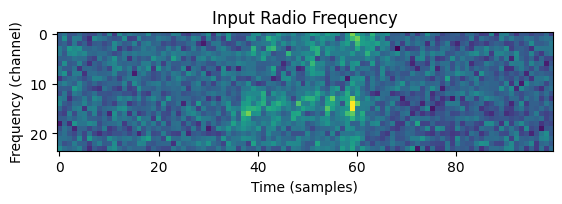

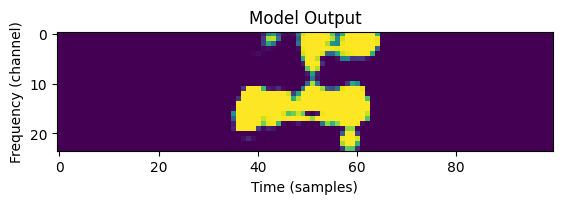

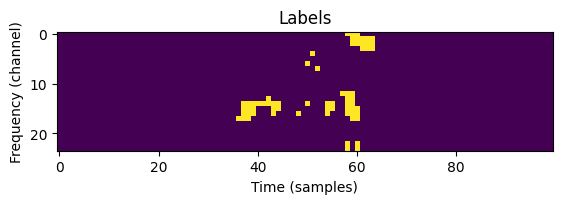

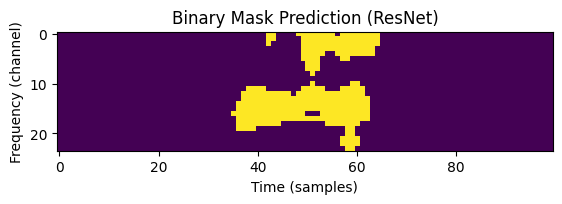

(1, 1, 24, 100)


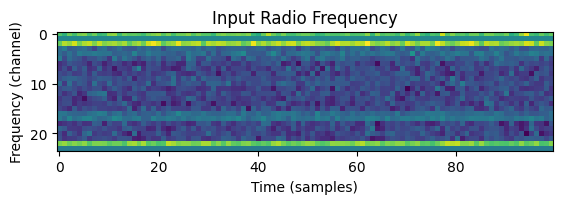

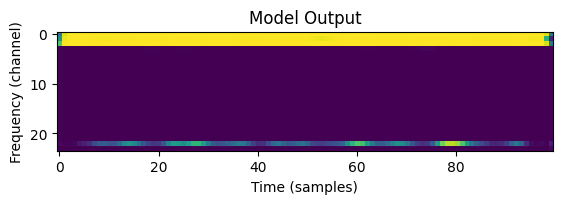

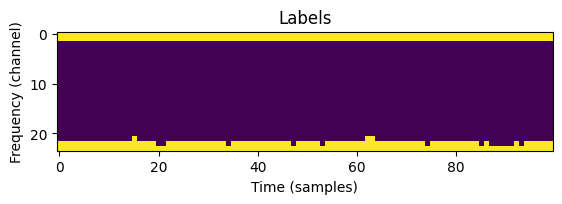

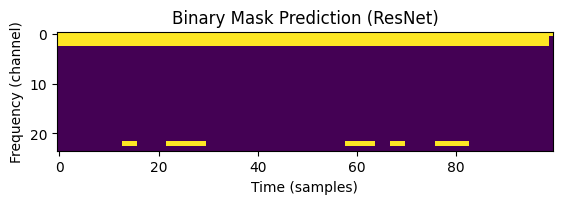

In [ ]:
#@title Vizualize Trained Model

indices = [543, 6342]

for i in indices:
  sample_data = data[i: i + 1]
  print(np.shape(sample_data))
  sample_labels = labels[i: i + 1]
  sample_data = (sample_data - np.mean(sample_data)) / np.std(sample_data)

  _, sample_loader = load_data(sample_data, sample_labels, 1)
  visualize(0.4, model, sample_loader)

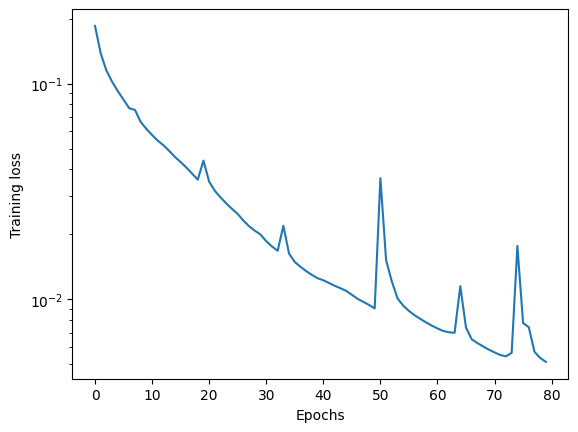

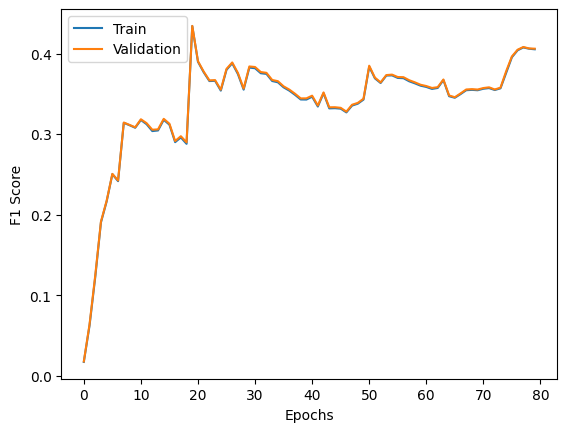

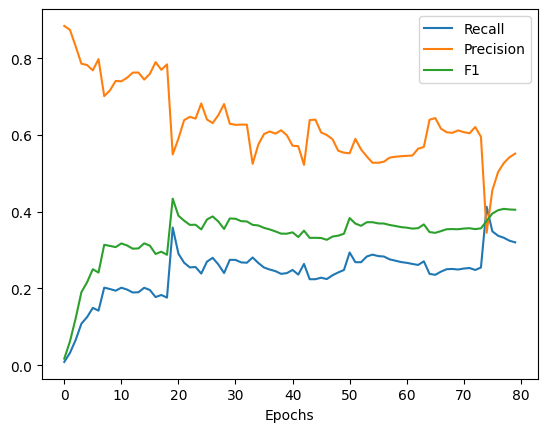

In [ ]:
#@title Plotting Loss Curves

def plot_curves(losses):
  plt.figure()
  plt.plot(losses['epoch'], losses['train_loss'])
  plt.xlabel("Epochs")
  plt.ylabel("Training loss")
  plt.yscale("log")
  plt.show()

  plt.figure()
  plt.plot(losses['epoch'], losses['f1_score_train'], label="Train")
  plt.plot(losses['epoch'], losses['f1_score_validation'], label="Validation")
  plt.legend()
  plt.xlabel("Epochs")
  plt.ylabel("F1 Score")
  plt.show()

  plt.figure()
  plt.plot(losses['epoch'], losses['recall_train'], label="Recall")
  plt.plot(losses['epoch'], losses['precision_train'], label="Precision")
  plt.plot(losses['epoch'], losses['f1_score_train'], label="F1")
  plt.legend()
  plt.xlabel("Epochs")
  plt.show()

losses = pd.read_csv('/content/drive/MyDrive/CS 101 Group/resnet_error/Real/realrfi2.csv')
plot_curves(losses)

AUC Score: 0.9992218623729268


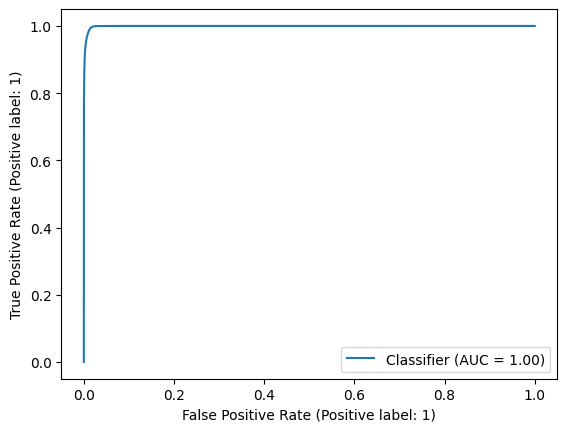

In [ ]:
#@title Plotting AUC Curves

import sklearn.metrics as sk

def plot_auc():
  y_pred, y_true = inference(model, test_loader, device)
  y_true, y_pred = np.ndarray.flatten(y_true), np.ndarray.flatten(y_pred)
  auc_score = sk.roc_auc_score(y_true, y_pred)
  print(f"AUC Score: {auc_score}")
  sk.RocCurveDisplay.from_predictions(y_true, y_pred)

plot_auc()